# Import

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import re
from skimage.feature import hog
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.colors as mcolors
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# Get Images and Labels 

In [2]:
def unify_classes(classes):
    unified_classes = set()
    class_mapping = {}

    for fruit in classes:
        if re.search(r'\s+\d+$', fruit):
            unified_name = re.sub(r'\s+\d+$', '', fruit)
        else:
            unified_name = fruit
        unified_classes.add(unified_name)
        class_mapping[fruit] = unified_name

    return sorted(list(unified_classes)), class_mapping

def getAllFruits(data_path):
    original_classes = []
    for fruit_path in glob.glob(os.path.join(data_path, "*")):
        fruit = fruit_path.split("/")[-1]
        original_classes.append(fruit)
    
    unified_classes, class_mapping = unify_classes(original_classes)
    return unified_classes, class_mapping

def getYourFruits(fruits, class_mapping, data_path, print_n=False):
    images = []
    labels = []
    for i, unified_name in enumerate(fruits):
        original_names = [k for k, v in class_mapping.items() if v == unified_name]
        j = 0
        for fruit_name in original_names:
            folder_pattern = os.path.join(data_path, fruit_name + "*")
            for fruit_folder in glob.glob(folder_pattern):
                for image_path in glob.glob(os.path.join(fruit_folder, "*.jpg")):
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                    image = cv2.resize(image, (dim, dim))
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    images.append(image)
                    labels.append(i)
                    j += 1
        if print_n:
            print(f"There are {j} images for {unified_name.upper()} in {data_path.split('/')[-1].upper()}")
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [3]:
dataset_path = "fruits-360_dataset_100x100/fruits-360"
train_path = os.path.join(dataset_path, "Training")
test_path = os.path.join(dataset_path, "Test")
dim = 100 


fruits, class_mapping = getAllFruits(train_path)
print(f"Number of unified classes: {len(fruits)}")
print(f"Unified Fruits: {fruits}")


X_train, y_train = getYourFruits(fruits, class_mapping, train_path, print_n=False)
print(f"Training data shape: {X_train.shape}, {y_train.shape}")


X_test, y_test = getYourFruits(fruits, class_mapping, test_path, print_n=False)
print(f"Test data shape: {X_test.shape}, {y_test.shape}")




Number of unified classes: 121
Unified Fruits: ['Apple', 'Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red', 'Apple Red Delicious', 'Apple Red Yellow', 'Apple hit', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cabbage white', 'Cactus fruit', 'Cantaloupe', 'Carambula', 'Carrot', 'Cauliflower', 'Cherry', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber', 'Cucumber Ripe', 'Dates', 'Eggplant', 'Eggplant long', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Nectarine Flat', 'Nut Forest

In [4]:
#global variables
class_names = fruits
n_components = 400

# 4.1 Feature Extraction: HOG and PCA

## 4.1.1 HOG

In [ ]:
def extract_hog_features(images, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    hog_features = []
    for image in images:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        features = hog(gray_image, 
                       orientations=orientations, 
                       pixels_per_cell=pixels_per_cell, 
                       cells_per_block=cells_per_block, 
                       block_norm='L2-Hys')
        hog_features.append(features)
    return np.array(hog_features)

In [6]:
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

X_train_hog[0].reshape(1,-1).shape

(1, 4356)

## 4.1.2 PCA

In [7]:
pca = PCA(n_components=n_components)

X_train_hog_pca = pca.fit_transform(X_train_hog)
X_test_hog_pca = pca.transform(X_test_hog)

In [ ]:

print("Cumulative Variance Explained by PCA:", np.sum(pca.explained_variance_ratio_))

Variația cumulativă explicată de PCA: 0.8021913806316159


## 4.1.3 Size Comparison

In [9]:
print("X_train_hog:", X_train_hog.shape)
print("X_test_hog:", X_test_hog.shape)

X_train_hog: (70491, 4356)
X_test_hog: (23619, 4356)


In [10]:
print("X_train_hog_pca:", X_train_hog_pca.shape)
print("X_test_hog_pca:", X_test_hog_pca.shape)

X_train_hog_pca: (70491, 400)
X_test_hog_pca: (23619, 400)


# 4.2 Viewing the Extracted Attributes

## 4.2.1 Class Balance Analysis

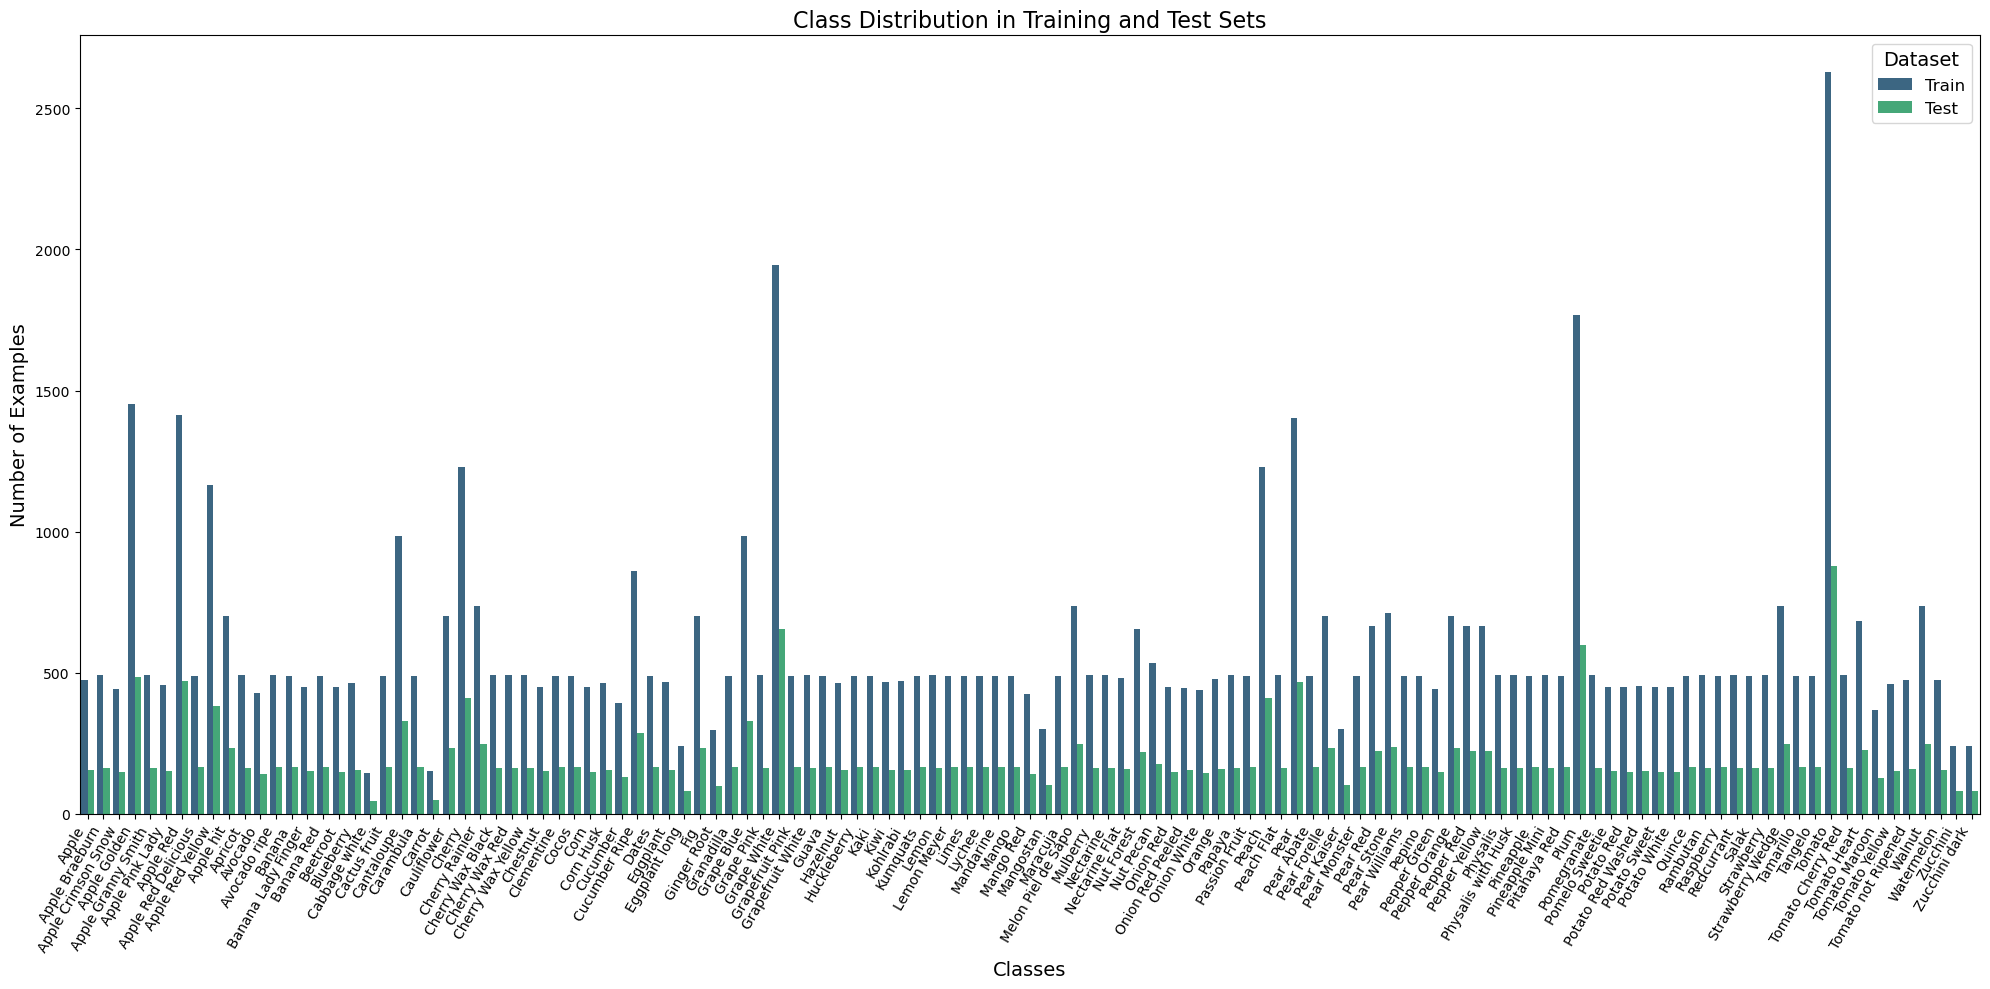

In [11]:
train_df = pd.DataFrame({'Label': y_train, 'Dataset': 'Train'})
test_df = pd.DataFrame({'Label': y_test, 'Dataset': 'Test'})
combined_df = pd.concat([train_df, test_df])

combined_df['Class'] = combined_df['Label'].map(lambda x: class_names[x])

plt.figure(figsize=(20, 10))
sns.countplot(data=combined_df, x='Class', hue='Dataset', palette='viridis')
plt.title("Class Distribution in Training and Test Sets", fontsize=16)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Number of Examples", fontsize=14)

plt.xticks(rotation=60, ha='right', fontsize=10)

plt.legend(title='Dataset', fontsize=12, title_fontsize=14)

plt.tight_layout() 
plt.show()


## 4.2.2. Quantitative / Qualitative Visualization of the Attribute Extraction Effect

### A) Quantitative Visualizations

#### A.1 Quantitative PCA Visualization: The Degree of Cumulative Variance Explained by the Selected Number of Principal Components

Numărul de componente principale selectate: 400


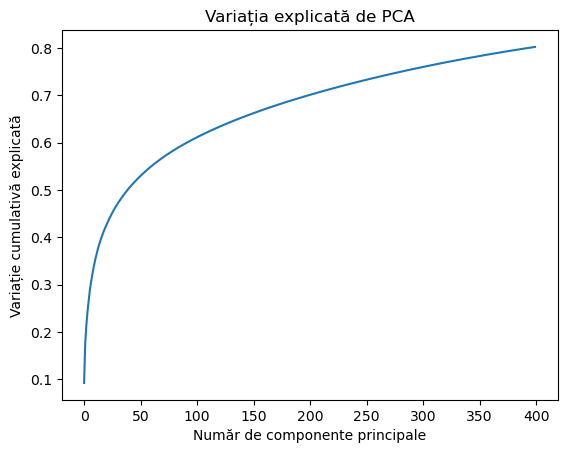

In [ ]:
print("Number of Selected Principal Components:", X_train_hog_pca.shape[1])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Explained by PCA')
plt.show()

### B) Qualitative Visualization

In [ ]:
# top 10 classes/fruits
y_train_series = pd.Series(y_train)
class_frequencies = y_train_series.value_counts()
top_10_classes = class_frequencies.head(10).index.tolist()
X_train_flattened = X_train.reshape(X_train.shape[0], -1)

#### B.1 For the PCA method, Visualization of Reconstructed Images Using the Selected Principal Components

In [14]:
def display_pca_reconstructed_images_per_class(X, y, class_names, top_classes, n_components):
 
    X_normalized = X / 255.0 if X.max() > 1 else X

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_normalized)
    X_reconstructed = pca.inverse_transform(X_pca)

    X_reconstructed = np.clip(X_reconstructed * 255, 0, 255)

    displayed_classes = {}

    for index, (image, label) in enumerate(zip(X, y)):
        if label in top_classes and label not in displayed_classes:
            displayed_classes[label] = index 

        if len(displayed_classes) == len(top_classes):
            break

    fig, axes = plt.subplots(2, len(top_classes), figsize=(20, 8))
    print(f"Number of components retained: {n_components}")
    
    fig.suptitle(f"PCA Reconstruction with {n_components} Components", fontsize=16)

    for i, class_label in enumerate(top_classes):
        class_index = displayed_classes[class_label]

        original_image = X[class_index].reshape(100, 100, 3)
        reconstructed_image = X_reconstructed[class_index].reshape(100, 100, 3)

        axes[0, i].imshow(original_image.astype('uint8'))
        axes[0, i].set_title(class_names[class_label])
        axes[0, i].axis('off')

        axes[1, i].imshow(reconstructed_image.astype('uint8'))
        axes[1, i].axis('off')

    # Titles for rows
    axes[0, 0].set_ylabel("Original", fontsize=12)
    axes[1, 0].set_ylabel("Reconstructed", fontsize=12)

    plt.tight_layout()
    plt.show()


Number of components retained: 400


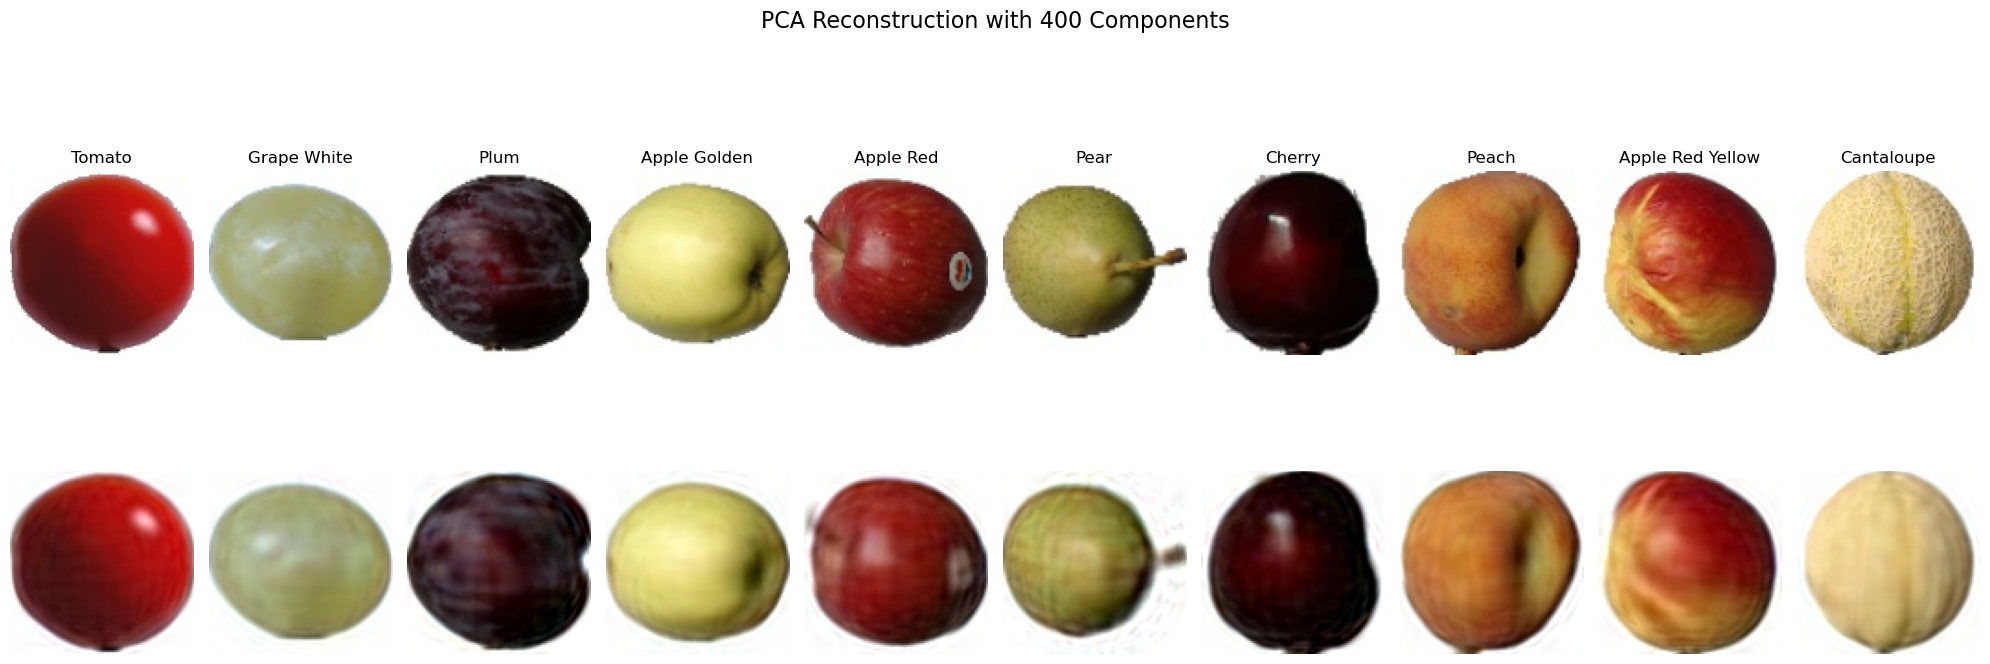

In [15]:
display_pca_reconstructed_images_per_class(
    X=X_train_flattened,
    y=y_train,
    class_names=fruits,
    top_classes=top_10_classes,
    n_components=n_components
)

#### B.2 For the HOG method

In [16]:

def display_hog_images(X, y, class_names, top_classes, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    displayed_classes = set()
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.ravel()

    for i, (image, label) in enumerate(zip(X, y)):
        if label in top_classes and label not in displayed_classes:
            displayed_classes.add(label)

            grayscale_image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])
            
            _, hog_image = hog(grayscale_image,
                               pixels_per_cell=pixels_per_cell, 
                               cells_per_block=cells_per_block, 
                               orientations=orientations,
                               block_norm='L2-Hys', 
                               visualize=True)
            
            class_index = top_classes.index(label)
            axes[class_index].imshow(hog_image, cmap='gray')
            axes[class_index].set_title(class_names[label])
            axes[class_index].axis('off')
        
        if len(displayed_classes) == len(top_classes):
            break
            
    plt.suptitle("HOG Visualizations for Top 10 Classes", fontsize=16)
    plt.show()

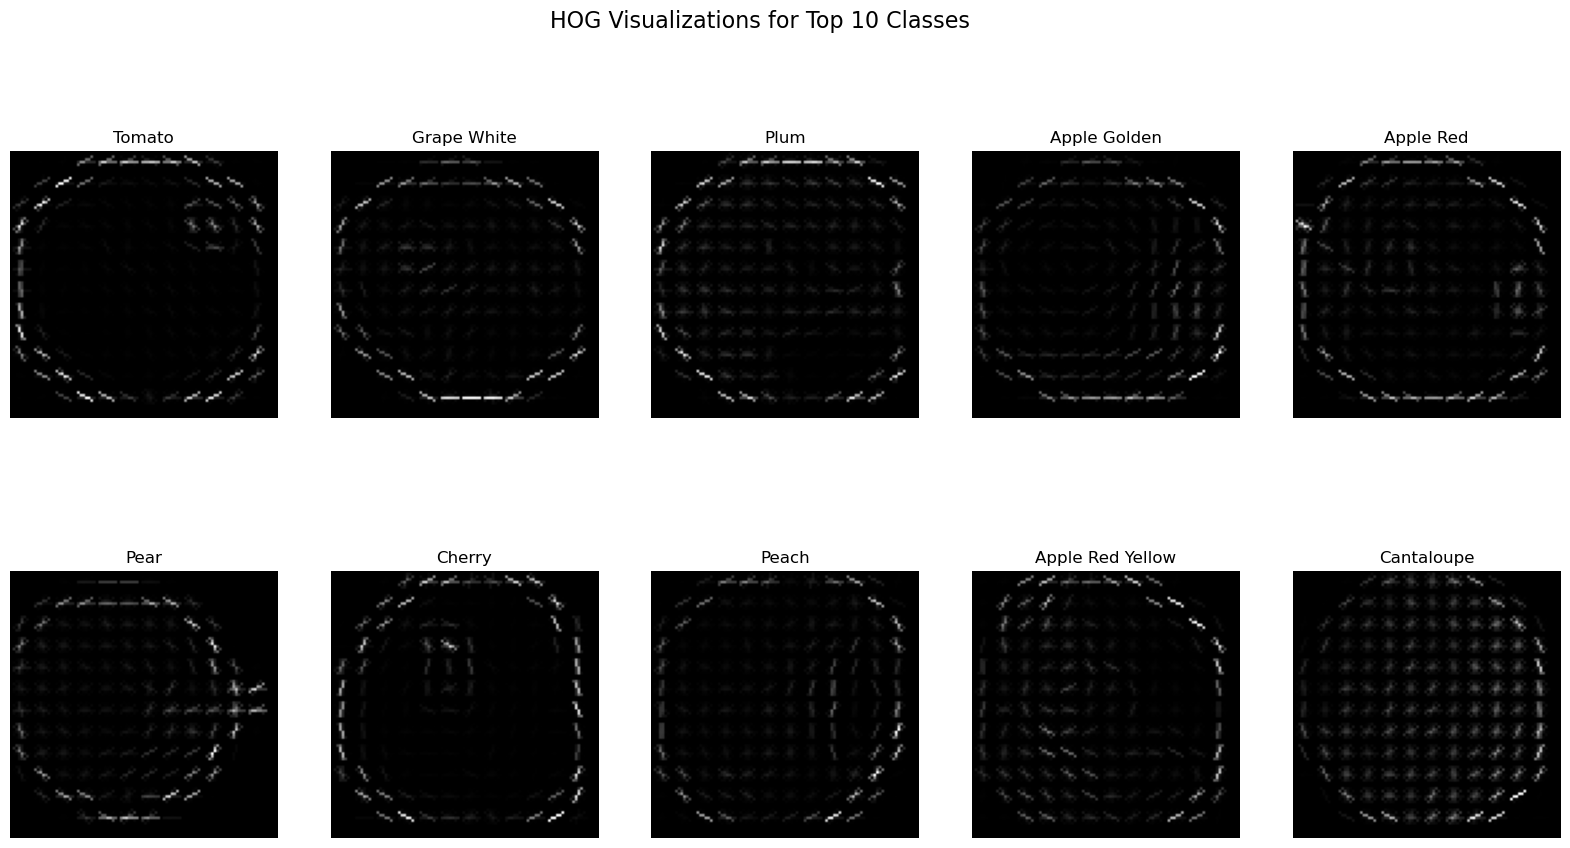

In [17]:
display_hog_images(
    X=X_train, 
    y=y_train, 
    class_names=fruits,
    top_classes=top_10_classes
)


# 4.3. Standardization and Attribute Selection

## 4.3.1 Standardization

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hog_pca)
X_test_scaled = scaler.transform(X_test_hog_pca)

## 4.3.2 Attribute Selection

In [19]:
selector = SelectPercentile(score_func=f_classif, percentile=50)  # Păstrează 50% din cele mai bune atribute
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

## 4.3.3 Size Comparison

In [20]:
print("X_train_hog_pca:", X_train_hog_pca.shape)
print("X_train_scaled:", X_train_scaled.shape)
print("X_train_selected:", X_train_selected.shape)


X_train_hog_pca: (70491, 400)
X_train_scaled: (70491, 400)
X_train_selected: (70491, 200)


# 4.4. Machine Learning Algorithms

## 4.4.1 Logistic Regression

In [21]:
X_train_small, X_val, y_train_small, y_val = train_test_split(
    X_train_selected, y_train, test_size=0.2, random_state=42
)

In [ ]:
print(f"Training Set Size: {X_train_small.shape}")
print(f"Validation Set Size: {X_val.shape}")

Dimensiunea setului de antrenare: (56392, 200)
Dimensiunea setului de validare: (14099, 200)


In [23]:
log_reg = LogisticRegression(max_iter=1000)

param_grid = {
    'C': [0.1, 1, 10],               
    'penalty': ['l2'],              
    'multi_class': ['ovr', 'multinomial'],          
    'solver': ['lbfgs']               
}

grid_search_log = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=3, scoring='accuracy',  verbose=2, n_jobs=-1)

In [ ]:
grid_search_log.fit(X_train_small, y_train_small)

print("Best Parameters:", grid_search_log.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END C=1, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   2.8s
[CV] END C=1, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   3.0s
[CV] END C=1, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   3.5s
[CV] END C=0.1, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   4.1s
[CV] END C=0.1, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   4.5s
[CV] END C=0.1, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   4.5s
[CV] END C=10, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   3.7s
[CV] END C=10, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   3.4s
[CV] END C=10, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   3.6s
[CV] END ...C=0.1, multi_class=ovr, penalty=l2, solver=lbfgs; total time=  18.0s
[CV] END ...C=0.1, multi_class=ovr, penalty=l2, solver=lbfgs; total time=  18.1s
[CV] END ...C

In [25]:
best_model_log = grid_search_log.best_estimator_

In [ ]:
y_pred_val_log = best_model_log.predict(X_val)
accuracy_val_log = accuracy_score(y_val, y_pred_val_log)
print(f"Accuracy on the Validation Set: {accuracy_val_log}")

Acuratețe pe setul de validare: 0.9938293495992624


In [ ]:
y_pred_test_log = best_model_log.predict(X_test_selected) 
accuracy_test_log = accuracy_score(y_test, y_pred_test_log)

print(f"Accuracy on the Test Set: {accuracy_test_log}")

Acuratețe pe setul de test: 0.8079512257081164


### Table Report for Logistic Regression

In [55]:
print("Test Classification Report for Logistic Regression:\n", classification_report(y_test, y_pred_test_log, target_names=fruits))

Test Classification Report for Logistic Regression:
                      precision    recall  f1-score   support

              Apple       0.99      1.00      0.99       157
     Apple Braeburn       0.73      0.63      0.68       164
 Apple Crimson Snow       0.72      0.87      0.79       148
       Apple Golden       0.87      0.81      0.84       485
 Apple Granny Smith       0.86      0.70      0.77       164
    Apple Pink Lady       0.82      0.99      0.90       152
          Apple Red       0.57      0.64      0.60       472
Apple Red Delicious       0.95      0.95      0.95       166
   Apple Red Yellow       0.58      0.62      0.60       383
          Apple hit       0.96      1.00      0.98       234
            Apricot       0.89      0.81      0.85       164
            Avocado       0.79      0.69      0.74       143
       Avocado ripe       0.87      0.98      0.92       166
             Banana       0.62      0.63      0.62       166
 Banana Lady Finger       0.55 

### Confusion Matrix for Logistic Regression

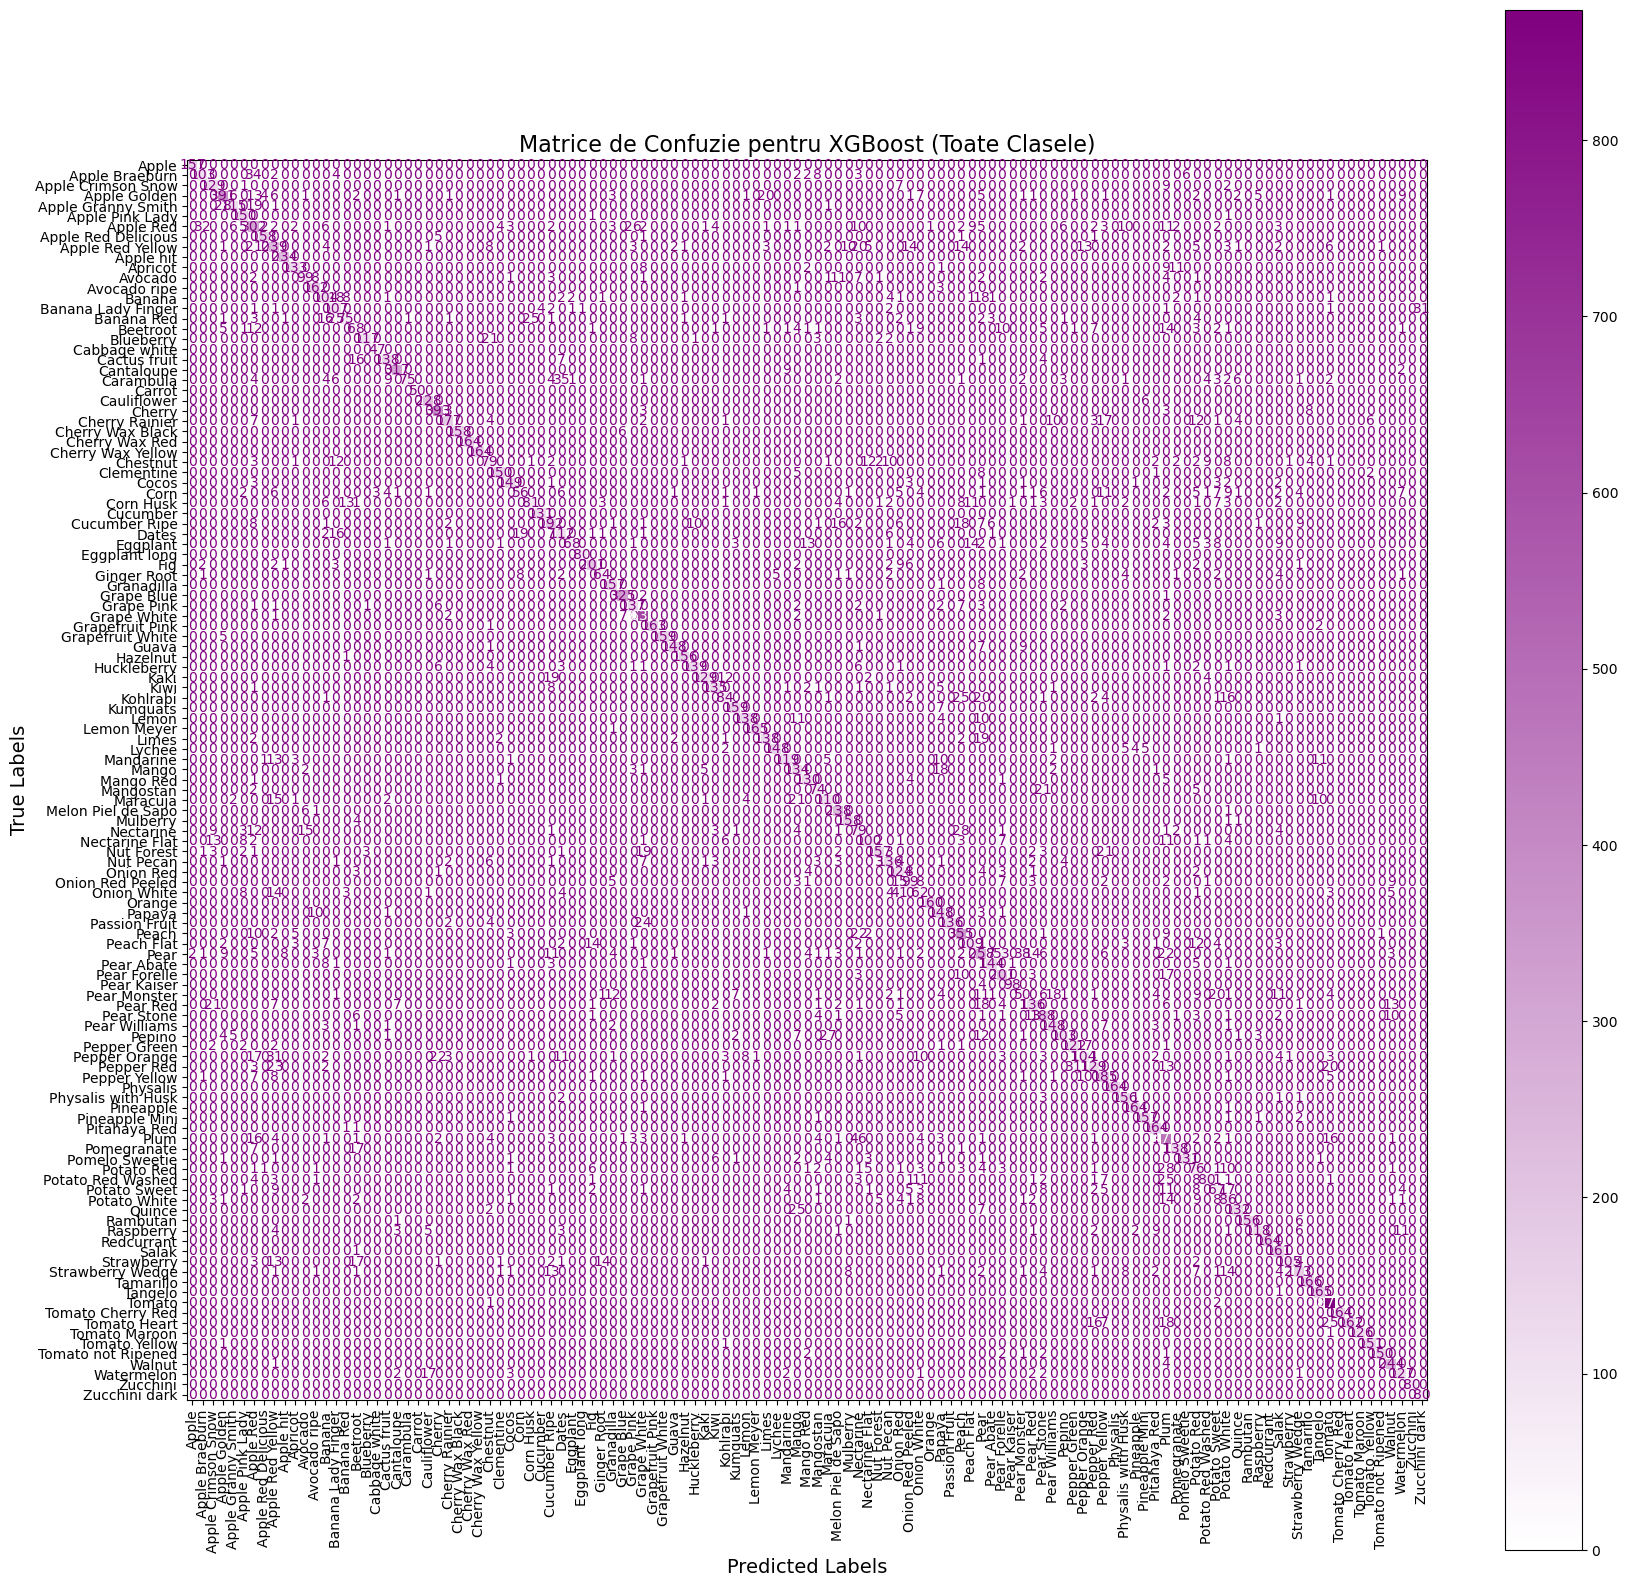

In [ ]:
conf_matrix_log = confusion_matrix(y_test, y_pred_test_log)

white_to_pink = mcolors.LinearSegmentedColormap.from_list("white_to_pink", ["white", "purple"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_log, display_labels=class_names)

fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(cmap=white_to_pink, ax=ax, xticks_rotation='vertical')

plt.title("Confusion Matrix for Logistic Regression", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)

plt.show()


## 4.4.2. SVM

In [30]:
svm = SVC()

param_grid_svm = {
    'C': [0.1, 1, 10],                  
    'kernel': ['linear', 'rbf', 'poly']  
}

grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)


In [ ]:
grid_search_svm.fit(X_train_small, y_train_small)
print("Best parameters for SVM:", grid_search_svm.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ...............................C=0.1, kernel=linear; total time= 3.3min
[CV] END .................................C=1, kernel=linear; total time= 3.3min
[CV] END ...............................C=0.1, kernel=linear; total time= 3.7min
[CV] END ...............................C=0.1, kernel=linear; total time= 3.7min
[CV] END .................................C=1, kernel=linear; total time= 3.8min
[CV] END .................................C=1, kernel=linear; total time= 3.8min
[CV] END .................................C=0.1, kernel=poly; total time= 7.3min
[CV] END .................................C=0.1, kernel=poly; total time= 7.3min
[CV] END .................................C=0.1, kernel=poly; total time= 7.8min
[CV] END ..................................C=0.1, kernel=rbf; total time= 7.9min
[CV] END ..................................C=0.1, kernel=rbf; total time= 7.9min
[CV] END ..................................C=0.1,

In [32]:
best_model_svm = grid_search_svm.best_estimator_

In [ ]:
y_pred_val_svm = best_model_svm.predict(X_val)
accuracy_val_svm = accuracy_score(y_val, y_pred_val_svm)

print(f"Accuracy on the Validation Set: {accuracy_val_svm}")

Acuratețe pe setul de validare: 0.9996453649194978


In [ ]:
y_pred_test_svm = best_model_svm.predict(X_test_selected)
accuracy_test_svm = accuracy_score(y_test, y_pred_test_svm)

In [ ]:
print(f"Accuracy on the Test Set: {accuracy_test_svm}")

Acuratețe pe setul de testare: 0.8731106312714341


### Table Report for SVM

In [ ]:
print("Test Classification Report for SVM:\n", classification_report(y_test, y_pred_test_svm, target_names=fruits))

### Confusion Matrix for SVM

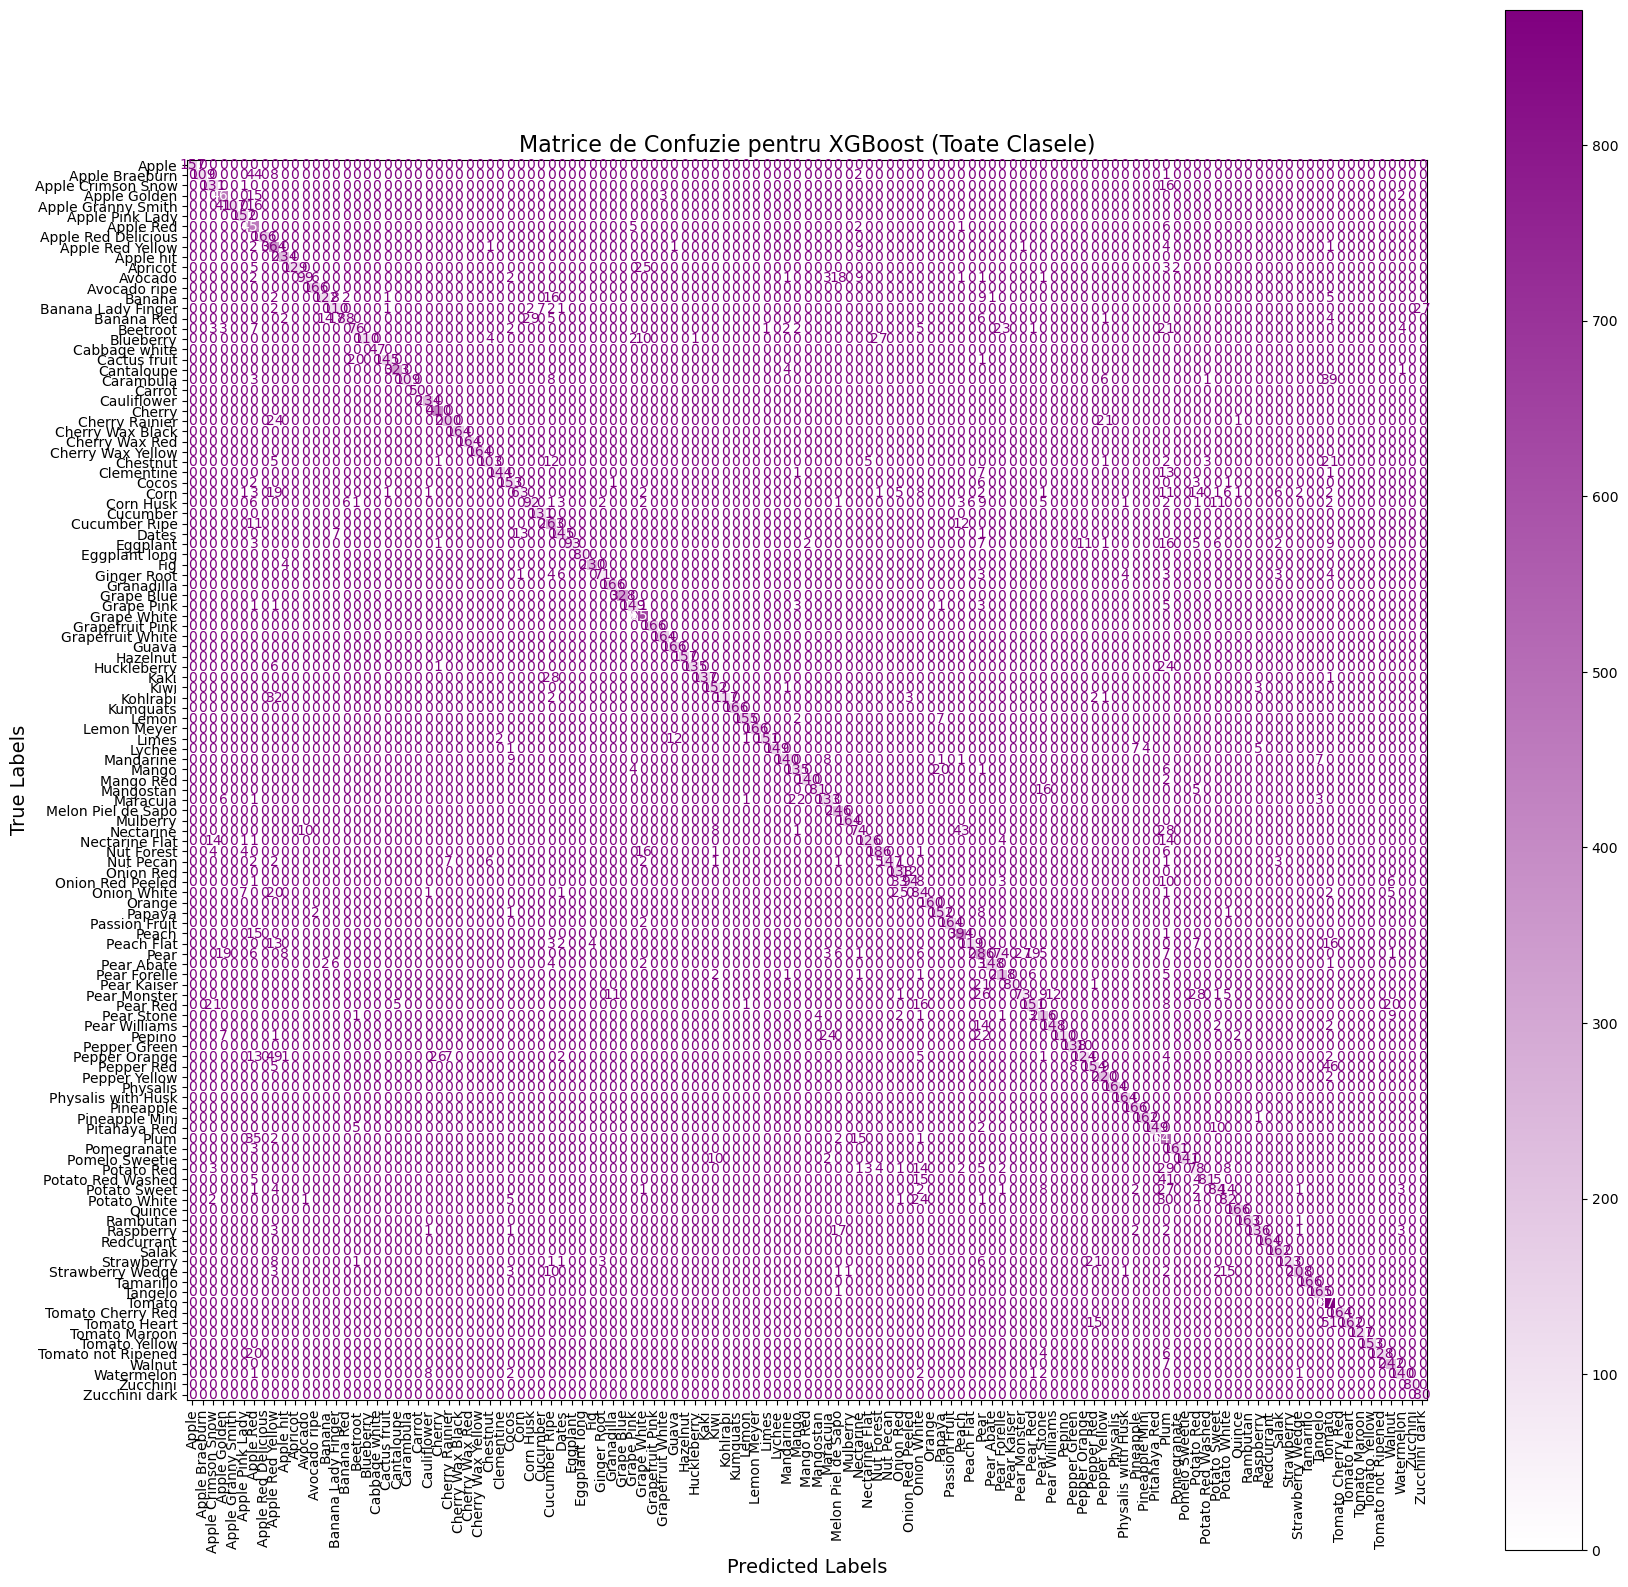

In [ ]:
conf_matrix_svm = confusion_matrix(y_test, y_pred_test_svm)

white_to_pink = mcolors.LinearSegmentedColormap.from_list("white_to_pink", ["white", "purple"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(cmap=white_to_pink, ax=ax, xticks_rotation='vertical')

plt.title("Confusion Matrix for SVM", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)

plt.show()


## 4.4.3. RandomForest 

In [39]:
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20],
    'max_samples': [0.6, 0.8, 1.0]
}

grid_search_rf = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid_rf, 
    cv=3, 
    scoring='accuracy', 
    verbose=2, 
    n_jobs=-1
)

In [ ]:
grid_search_rf.fit(X_train_small, y_train_small)

print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END .....max_depth=10, max_samples=0.6, n_estimators=50; total time=  35.4s
[CV] END .....max_depth=10, max_samples=0.6, n_estimators=50; total time=  35.4s
[CV] END .....max_depth=10, max_samples=0.6, n_estimators=50; total time=  35.5s
[CV] END .....max_depth=10, max_samples=0.8, n_estimators=50; total time=  43.6s
[CV] END .....max_depth=10, max_samples=0.8, n_estimators=50; total time=  43.6s
[CV] END .....max_depth=10, max_samples=0.8, n_estimators=50; total time=  43.6s
[CV] END ....max_depth=10, max_samples=0.6, n_estimators=100; total time= 1.2min
[CV] END ....max_depth=10, max_samples=0.6, n_estimators=100; total time= 1.2min
[CV] END ....max_depth=10, max_samples=0.6, n_estimators=100; total time= 1.2min
[CV] END .....max_depth=10, max_samples=1.0, n_estimators=50; total time=  49.4s
[CV] END .....max_depth=10, max_samples=1.0, n_estimators=50; total time=  49.6s
[CV] END .....max_depth=10, max_samples=1.0, n_e

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .....max_depth=20, max_samples=0.8, n_estimators=50; total time= 1.2min
[CV] END .....max_depth=20, max_samples=0.8, n_estimators=50; total time= 1.2min
[CV] END ....max_depth=20, max_samples=0.6, n_estimators=100; total time= 2.0min
[CV] END ....max_depth=20, max_samples=0.6, n_estimators=100; total time= 1.9min
[CV] END ....max_depth=20, max_samples=0.6, n_estimators=100; total time= 1.9min
[CV] END ....max_depth=10, max_samples=1.0, n_estimators=200; total time= 5.0min
[CV] END ....max_depth=10, max_samples=1.0, n_estimators=200; total time= 5.0min
[CV] END ....max_depth=10, max_samples=1.0, n_estimators=200; total time= 5.0min
[CV] END .....max_depth=20, max_samples=1.0, n_estimators=50; total time= 1.4min
[CV] END .....max_depth=20, max_samples=1.0, n_estimators=50; total time= 1.4min
[CV] END .....max_depth=20, max_samples=1.0, n_estimators=50; total time= 1.4min
[CV] END ....max_depth=20, max_samples=0.8, n_estimators=100; total time= 2.4min
[CV] END ....max_depth=20, m

In [41]:
best_model_rf = grid_search_rf.best_estimator_

In [ ]:
y_pred_val_rf = best_model_rf.predict(X_val)
accuracy_val_rf = accuracy_score(y_val, y_pred_val_rf)
print(f"Accuracy on the Validation Set: {accuracy_val_rf}")

Acuratețe pe setul de validare: 0.9948932548407688


In [ ]:
y_pred_test_rf = best_model_rf.predict(X_test_selected)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)
print(f"Accuracy on the Test Set: {accuracy_test_rf}")

Acuratețe pe setul de test: 0.7800499597781447


### Table Report for RandomForest

In [54]:
print("Test Classification Report for RandomForest:\n", classification_report(y_test, y_pred_test_rf, target_names=fruits))

Test Classification Report for RandomForest:
                      precision    recall  f1-score   support

              Apple       0.80      1.00      0.89       157
     Apple Braeburn       0.95      0.65      0.77       164
 Apple Crimson Snow       0.55      0.82      0.66       148
       Apple Golden       0.70      0.88      0.78       485
 Apple Granny Smith       0.93      0.63      0.75       164
    Apple Pink Lady       0.88      0.74      0.80       152
          Apple Red       0.59      0.81      0.68       472
Apple Red Delicious       0.99      0.96      0.98       166
   Apple Red Yellow       0.75      0.77      0.76       383
          Apple hit       0.87      1.00      0.93       234
            Apricot       0.95      0.63      0.76       164
            Avocado       0.89      0.66      0.76       143
       Avocado ripe       0.99      0.89      0.94       166
             Banana       0.91      0.69      0.79       166
 Banana Lady Finger       0.79      0.

### Confusion Matrix for RandomForest

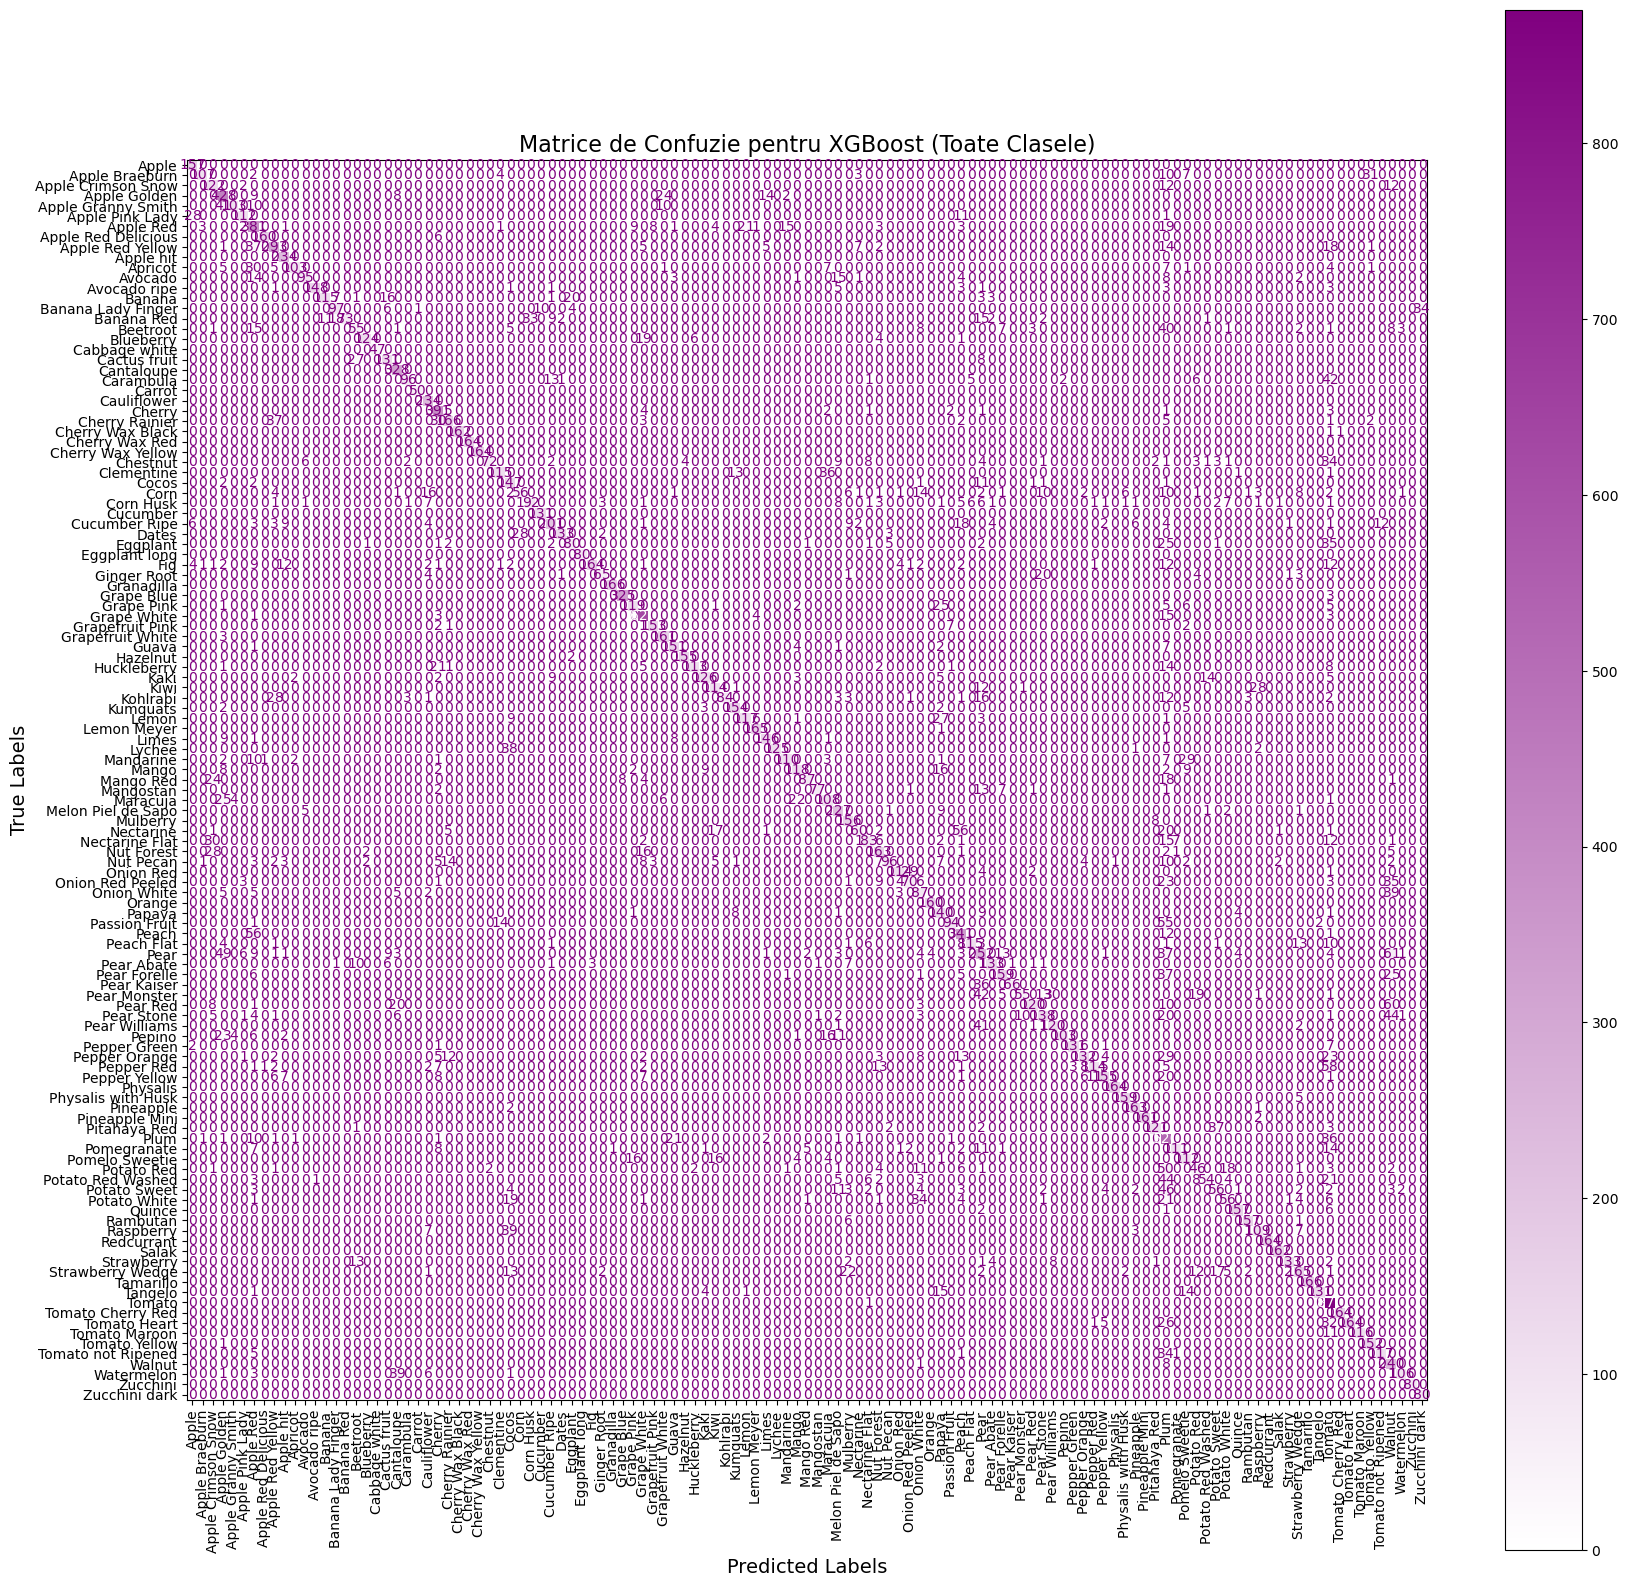

In [ ]:
conf_matrix_rf = confusion_matrix(y_test, y_pred_test_rf)

white_to_pink = mcolors.LinearSegmentedColormap.from_list("white_to_pink", ["white", "purple"])

disp = ConfusionMatrixDisplay(confusion_matrix=rf, display_labels=class_names)

fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(cmap=white_to_pink, ax=ax, xticks_rotation='vertical')

plt.title("Confusion Matrix for RandomForest", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)

plt.show()


## 4.4.4 GradientBoosted Tree

In [45]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb, 
    param_grid=param_grid_xgb, 
    cv=3, 
    scoring='accuracy', 
    verbose=2, 
    n_jobs=-1
)

In [ ]:
grid_search_xgb.fit(X_train_small, y_train_small)

print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:04:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:04:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:04:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:04:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time= 2.0min
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time= 2.0min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:06:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:06:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time= 2.0min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:06:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time= 3.0min
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time= 3.0min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:07:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:07:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time= 3.0min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:07:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time= 4.1min
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time= 4.1min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:08:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:08:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time= 4.2min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:08:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time= 3.9min
[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time= 3.9min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:12:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:12:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time= 3.9min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:12:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time= 6.2min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time= 6.2min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:12:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:12:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time= 6.2min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:12:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time= 8.8min
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time= 8.8min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time= 8.8min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:13:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:13:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time= 2.4min
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time= 2.4min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:15:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time= 2.4min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:15:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:15:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=15.4min


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=15.4min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=15.4min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:23:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:23:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time= 7.3min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time= 7.3min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:23:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:23:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:23:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time=10.5min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time=10.5min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time= 7.4min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:23:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:23:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:23:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time=10.6min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:23:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time= 5.0min
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time= 5.0min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:28:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:28:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time= 5.1min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:28:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time= 9.7min
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time= 9.7min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:32:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:32:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time= 9.8min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:33:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=22.6min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=22.7min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:35:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:35:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=22.7min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:35:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=14.4min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=14.4min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:37:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:37:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=14.6min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:37:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time= 6.2min
[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time= 6.2min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:39:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:39:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time= 6.3min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:39:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=3, n_estimators=50; total time= 4.0min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:43:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=3, n_estimators=50; total time= 4.1min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:43:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=3, n_estimators=50; total time= 4.0min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:43:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=17.9min
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=17.9min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:46:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:46:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=17.9min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:46:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time=12.1min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:47:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time=12.1min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:47:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time=12.1min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:47:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=100; total time= 9.5min
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=100; total time= 9.5min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:52:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:52:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=100; total time= 9.5min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:52:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=5, n_estimators=50; total time= 6.2min
[CV] END ....learning_rate=0.2, max_depth=5, n_estimators=50; total time= 6.2min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:53:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:53:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=5, n_estimators=50; total time= 6.1min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:53:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time=20.7min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:58:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time=20.8min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:58:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time=20.8min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:58:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=200; total time=16.2min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:02:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=200; total time=16.3min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:02:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=200; total time=16.3min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:02:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time=10.2min
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time=10.1min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:02:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:02:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time=10.0min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:02:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=7, n_estimators=50; total time= 6.1min
[CV] END ....learning_rate=0.2, max_depth=7, n_estimators=50; total time= 6.0min
[CV] END ....learning_rate=0.2, max_depth=7, n_estimators=50; total time= 5.9min
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=200; total time=13.7min
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=200; total time=13.8min
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=200; total time=13.8min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time= 6.5min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time= 6.4min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time= 6.4min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=200; total time= 8.3min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=200; total time= 8.3min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=200; total time= 8.2min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:11:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Cei mai buni parametri pentru XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}


In [47]:
best_model_xgb = grid_search_xgb.best_estimator_

In [ ]:
y_pred_val_xgb = best_model_xgb.predict(X_val)
accuracy_val_xgb = accuracy_score(y_val, y_pred_val_xgb)

print(f"Accuracy on the Validation Set: {accuracy_val_xgb}")

Acuratețe pe setul de validare: 0.9938293495992624


In [ ]:
y_pred_test_xgb = best_model_xgb.predict(X_test_selected)
accuracy_test_xgb = accuracy_score(y_test, y_pred_test_xgb)

print(f"Accuracy on the Test Set: {accuracy_test_xgb}")

Acuratețe pe setul de test: 0.7730217198018544


### Table Report for XGBoost

In [53]:
print("Test Classification Report for XGBoost:\n", classification_report(y_test, y_pred_test_xgb, target_names=fruits))

Test Classification Report for XGBoost:
                      precision    recall  f1-score   support

              Apple       0.95      1.00      0.98       157
     Apple Braeburn       0.88      0.62      0.73       164
 Apple Crimson Snow       0.68      0.67      0.67       148
       Apple Golden       0.84      0.79      0.81       485
 Apple Granny Smith       0.82      0.68      0.74       164
    Apple Pink Lady       0.64      0.90      0.75       152
          Apple Red       0.52      0.77      0.62       472
Apple Red Delicious       0.99      0.96      0.98       166
   Apple Red Yellow       0.67      0.76      0.71       383
          Apple hit       0.83      1.00      0.91       234
            Apricot       0.72      0.60      0.65       164
            Avocado       0.81      0.64      0.72       143
       Avocado ripe       0.91      0.86      0.89       166
             Banana       0.84      0.61      0.71       166
 Banana Lady Finger       0.60      0.64   

### Confusion Matrix for XGBoost 

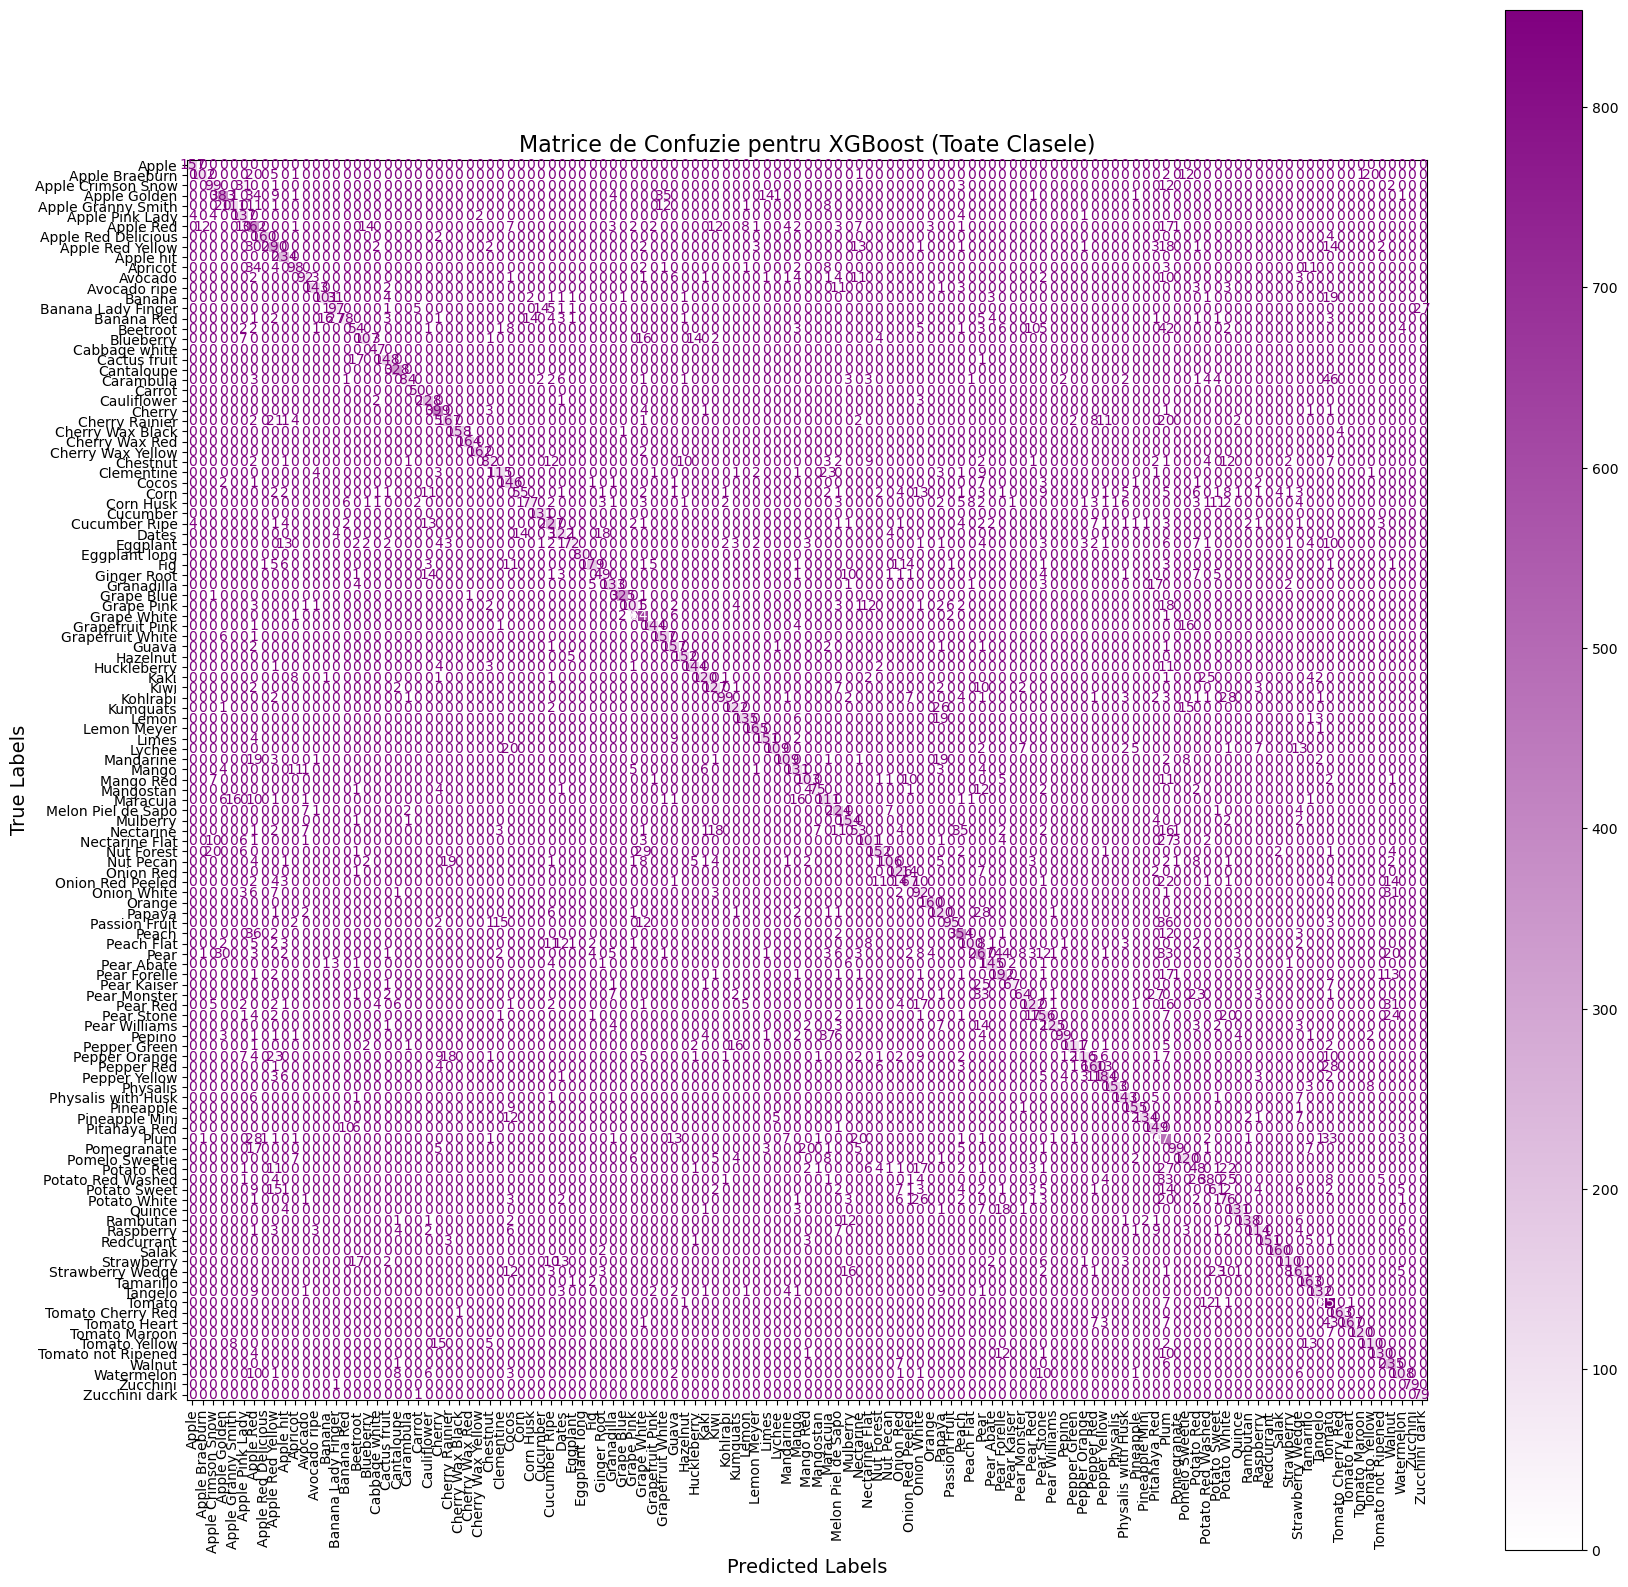

In [ ]:
conf_matrix_xgb = confusion_matrix(y_test, y_pred_test_xgb)

white_to_pink = mcolors.LinearSegmentedColormap.from_list("white_to_pink", ["white", "purple"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb, display_labels=class_names)

fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(cmap=white_to_pink, ax=ax, xticks_rotation='vertical')

plt.title("Confusion Matrix for XGBoost", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)

plt.show()
